In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

In [ ]:
summary = pd.read_csv("../Summary_cut.csv", index_col=0)
summary.cell_type = summary.cell_type.astype("category")
summary.sample_type = summary.sample_type.astype("category")
summary.sort_values(by="age", inplace=True)
summary.reset_index(inplace=True)
# neglect some duplicated colonies e.g. summary.colony_ID == "11_E07"
summary = summary.merge(
    summary[["donor_id", "age"]]
    .groupby("donor_id")
    .count()
    .reset_index()
    .rename(columns={"age": "cells"}),
    on="donor_id",
    validate="many_to_one",
    how="left",
)
summary.dtypes

In [3]:
summary.describe()

,age,timepoint,number_mutations,mean_depth,sub_adj,number_indels,indel_adj,number_non_syn,tel_length,cells
count,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,2144.000000,3592.000000
mean,50.219655,1.187639,795.948775,14.133580,900.998466,24.220212,40.237820,6.059577,5868.460308,368.912584
std,28.490569,0.504376,463.664569,4.000775,487.679599,18.316981,22.774641,4.337902,20606.138592,53.000309
min,0.000000,1.000000,19.000000,7.035980,28.858071,0.000000,-0.226591,0.000000,0.000000,216.000000
25%,29.000000,1.000000,447.000000,11.868800,583.545154,8.750000,23.730203,2.000000,2699.675000,361.000000
50%,63.000000,1.000000,847.000000,13.344268,1025.540507,19.000000,42.833953,6.000000,3444.050000,367.000000
75%,76.000000,1.000000,1225.000000,15.452511,1340.645960,39.000000,58.620753,9.000000,4916.675000,390.000000
max,81.000000,3.000000,1637.000000,58.579641,1723.483190,79.000000,98.615993,21.000000,754884.600000,451.000000


In [4]:
summary.cell_type.value_counts()

cell_type
HSC           3374
Progenitor     218
Name: count, dtype: int64

In [5]:
summary.sample_type.value_counts()

sample_type
BM    2177
PB     809
CB     606
Name: count, dtype: int64

In [6]:
summary

,donor_id,age,colony_ID,original_ID,cell_type,sample_type,timepoint,PDID,number_mutations,mean_depth,sub_adj,number_indels,indel_adj,number_non_syn,platform,tel_length,cells
0,CB002,0,31_E04,6_A07,HSC,CB,1,PD45517b_lo0029,49,19.125047,50.628760,3,3.573468,0,novaseq,NaN,390
1,CB002,0,11_H08,5_A04,HSC,CB,1,PD45517b_lo0230,50,15.250398,54.443145,1,1.994759,0,novaseq,NaN,390
2,CB002,0,11_A09,2_C01,HSC,CB,1,PD45517b_lo0231,48,15.080891,52.638739,3,4.017367,0,novaseq,NaN,390
3,CB002,0,11_B09,2_E01,HSC,CB,1,PD45517b_lo0232,32,14.263728,37.705967,0,1.132153,0,novaseq,NaN,390
4,CB002,0,11_C09,2_G03,HSC,CB,1,PD45517b_lo0233,47,13.567598,53.802023,1,2.237967,0,novaseq,NaN,390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3587,KX003,81,12_B06,5_E10,HSC,BM,1,PD43974fr,1269,11.782490,1404.174094,53,79.173327,8,hiseq,2360.5,343
3588,KX003,81,12_E06,7_E04,HSC,BM,1,PD43974fu,1427,14.229388,1495.620311,46,65.876283,14,hiseq,1740.8,343
3589,KX003,81,12_F06,7_H04,HSC,BM,1,PD43974fv,1462,14.397643,1527.482658,38,57.490339,10,novaseq,4160.0,343
3590,KX003,81,11_F09,3_H07,HSC,BM,1,PD43974bt,1325,12.712325,1429.525518,50,73.622101,10,hiseq,2108.3,343


<Axes: xlabel='age', ylabel='number_mutations'>

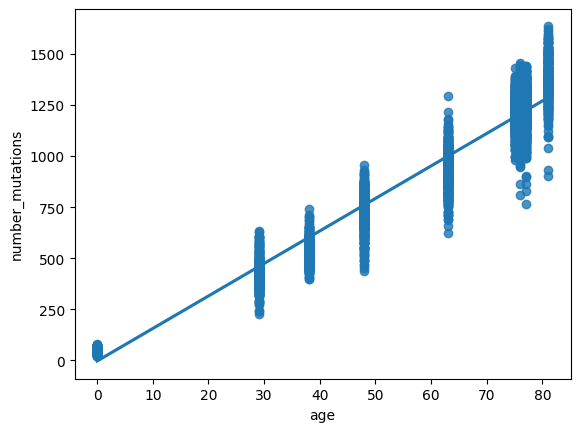

In [7]:
sns.regplot(data=summary, x="age", y="number_mutations", scatter_kws={"marker": "x"})

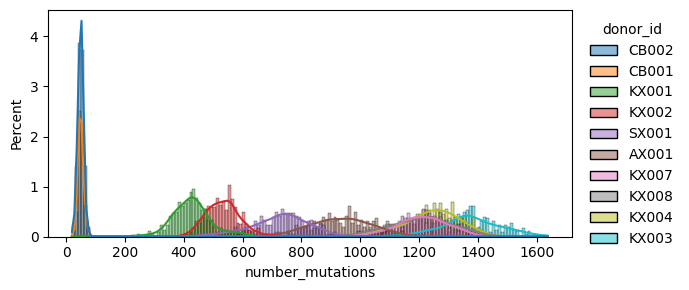

In [8]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(7, 3))
sns.histplot(
    data=summary,
    x="number_mutations",
    hue="donor_id",
    kde=True,
    binwidth=10,
    ax=ax,
    stat="percent",
)
sns.move_legend(ax, bbox_to_anchor=(1.01, 1), loc="upper left", frameon=False)
plt.show()

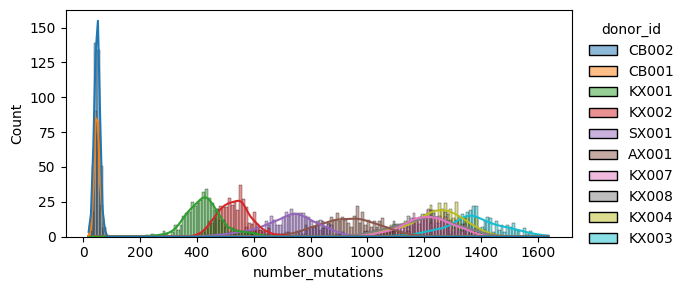

In [9]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(7, 3))
sns.histplot(
    data=summary,
    x="number_mutations",
    hue="donor_id",
    kde=True,
    binwidth=10,
    ax=ax,
    stat="count",
)
sns.move_legend(ax, bbox_to_anchor=(1.01, 1), loc="upper left", frameon=False)
plt.show()

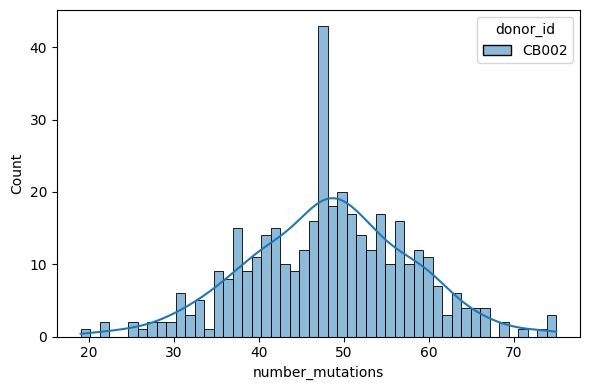

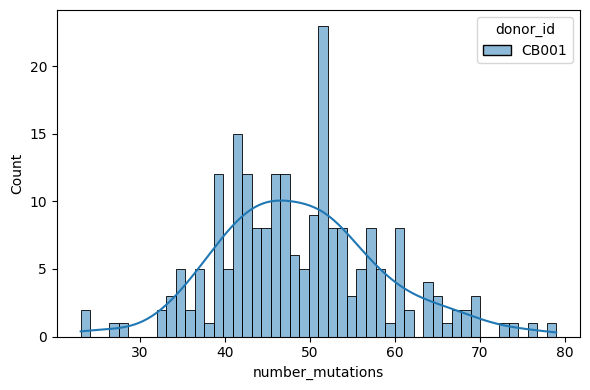

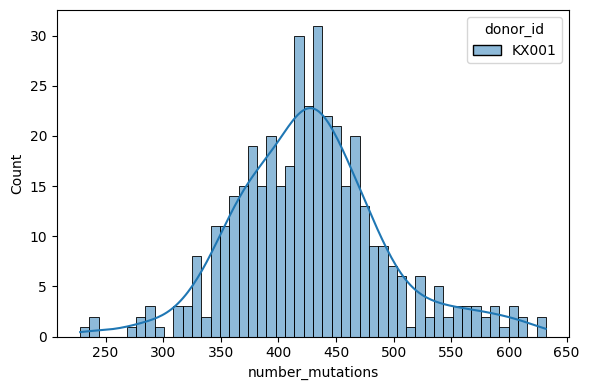

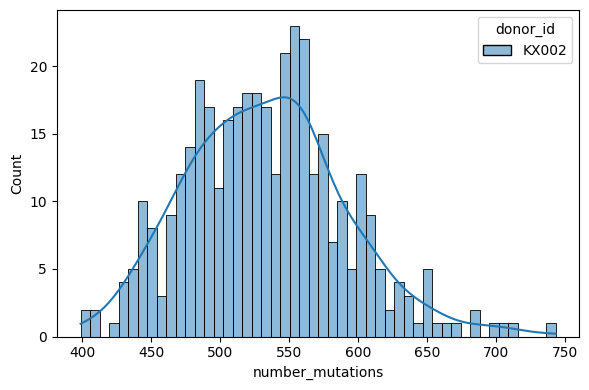

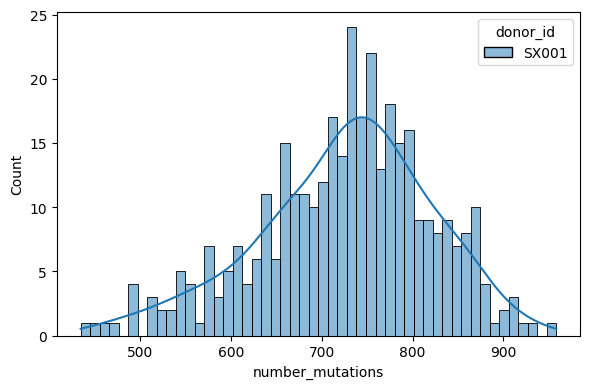

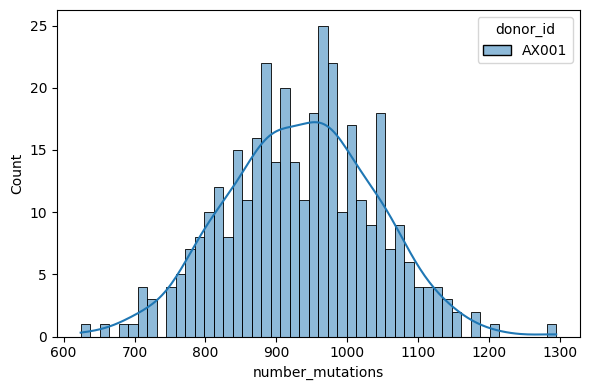

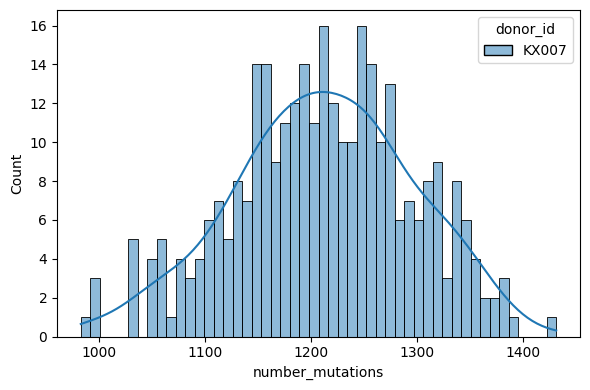

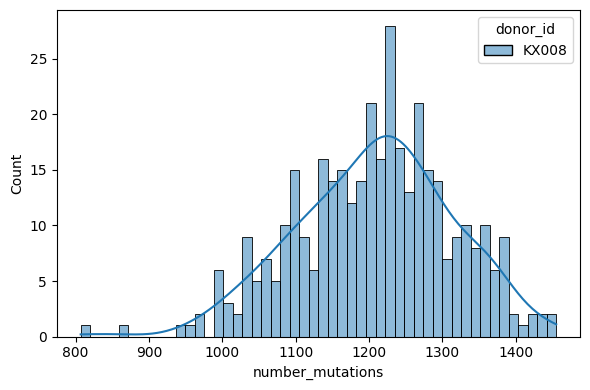

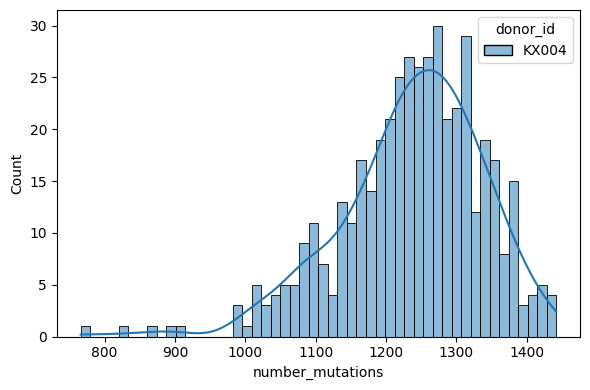

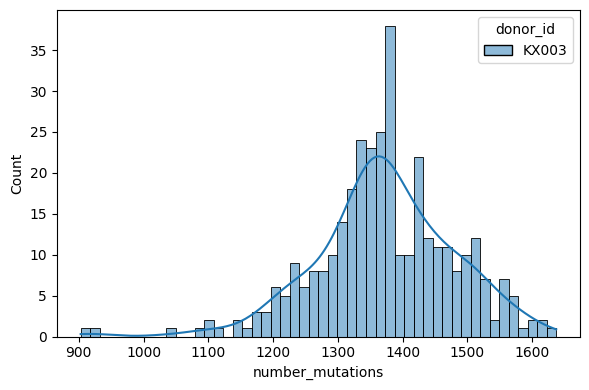

In [10]:
for i in summary.donor_id.unique():
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 4))
    sns.histplot(
        data=summary[summary.donor_id == i],
        x="number_mutations",
        hue="donor_id",
        kde=True,
        bins=50,
        ax=ax,
        stat="count",
    )
    plt.show()

## Entropy
Based on the code they [developped](https://github.com/emily-mitchell/normal_haematopoiesis/blob/23d221e8d125d78c1e8bcbe05d41d0f3594b0cfb/4_phylogeny_analysis/scripts/shannon_diversity.Rmd#L147), I think they define entropy as in [here](http://math.bu.edu/people/mkon/J6A.pdf) using the phylogenetic tree.
We just compute the entropy from the number of cells: we consider a class being the cells with the same number of mutations and compute the abbundance of those classes, that is the abbundance of cells with the same number of mutations.

In [11]:
# count the number of cells with the same number of mutations
test = (
    summary[["donor_id", "number_mutations", "age"]]
    .groupby(["donor_id", "number_mutations"])
    .count()
    .reset_index()
)
test.rename(columns={"age": "probs"}, inplace=True)
entropies = (
    test[["donor_id", "probs"]]
    .groupby("donor_id")
    .value_counts()
    .reset_index()
    .groupby("donor_id")
    .agg(stats.entropy)
    .reset_index()
    .rename(columns={"probs": "entropy"})
)
summary = summary.merge(entropies, how="left", on="donor_id", validate="many_to_one")

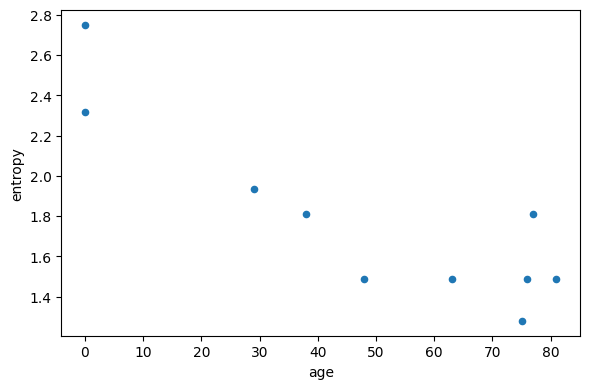

In [12]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 4))
summary.drop_duplicates(subset=["entropy", "donor_id"]).plot(
    x="age", y="entropy", ax=ax, kind="scatter"
)
plt.show()